# Example 5: Calibration of the Number of Periods for Convergence

The estimation of the growth factors assumes a given number of periods under which the model should converge. This variable is called 'steps'. This example shows how to choose an optimal 'steps', such that the volatility of the simulated indicators matches the empirical ones.

## Import the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import ppi
import calibration as cal

## Load data

In [2]:
data = pd.read_csv('final_sample_normalized.csv', sep='\t', header=0, low_memory=False, encoding='utf-16') # indicators
A = np.loadtxt('network.csv') # network
phi, tau = np.loadtxt('governance_params.csv') # governance parameters

## Prepare data for PPI

In [3]:
series = data[[str(year) for year in range(2006, 2017)]].values # extract the time series from the data
I0, T = ppi.get_targets(series) # use the helper function get_targets() to transform the final values into targets
R = data['instrumental'].values # extract the variable indicating which indicators are instrumental
colors = dict(zip(data.index, data.goalColor)) # build a dictionary mapping each indicator to its SDG color

## Calculate empirical volatility

In [4]:
chs_emp = (series[:, 1::]-series[:, 0:-1]).flatten()
chs_emp[chs_emp<0] = 0
vola_emp = chs_emp.std()    

## Estimate growth factors for different levels of 'steps'

The function 'find_steps' from the 'calibration.py' script tries different values for 'steps' until it finds one that matches the empirical volatility of the development indicators. The user shuold provide the initial level of 'steps' and, then, the function estimates the corresponding growth factors and the simulated volatility. If the synthetic volatility is larger than the empirical one, then the function increases 'steps' by one and repeats the procedure. This process continues until the function has fuond a 'steps' that yields a lower volatility than the empirical one.

Similar to the previous example, this illustration assumes large error thresholds and few Monte Carlo simulations in order to reduce the computational time.

In [5]:
%%time
# the line above prints the computation time after the estimation has finished
steps = 20 # the initial number of periods under which the model should converge
sample_size = 2 # the number of Monte Carlo simulations
dev_lim = 5 # the convergence error threshold
parallel_processes = 4 # the number of processes to be run in parallel

rec_alphas, rec_volas, rec_steps = cal.find_steps(I0, T, A=A, R=R, phi=phi, tau=tau, 
                                       vola_emp=vola_emp, steps=steps, sample_size=sample_size, 
                                       dev_lim=dev_lim, parallel_processes=parallel_processes)

Number of ticks to convergence: 20
Running iteration 1 ...
Obtained a mean average convergence time error of 4.570921985815603
Difference in volatility: 0.006825952754305999
Number of ticks to convergence: 21
Running iteration 1 ...
Obtained a mean average convergence time error of 3.9361702127659575
Difference in volatility: 0.005823123280013463
Number of ticks to convergence: 22
Running iteration 1 ...
Obtained a mean average convergence time error of 4.301418439716312
Difference in volatility: 0.005061726925054123
Number of ticks to convergence: 23
Running iteration 1 ...
Obtained a mean average convergence time error of 3.99290780141844
Difference in volatility: 0.006766757635562639
Number of ticks to convergence: 24
Running iteration 1 ...
Obtained a mean average convergence time error of 4.315602836879433
Difference in volatility: 0.0032258534022083125
Number of ticks to convergence: 25
Running iteration 1 ...
Obtained a mean average convergence time error of 4.308510638297872
Di

## Plot convergence levels

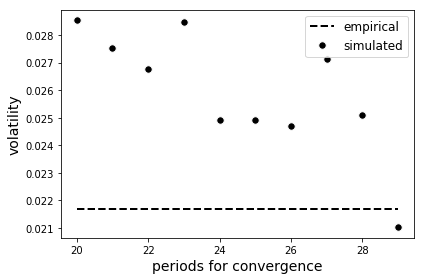

In [6]:
plt.plot(rec_steps, [vola_emp for step in rec_steps], '--k', linewidth=2)
plt.plot(rec_steps, rec_volas, '.k', markersize=15, mec='w',)
plt.xlabel('periods for convergence', fontsize=14)
plt.ylabel('volatility', fontsize=14)
plt.legend(['empirical', 'simulated'], fontsize=12)

plt.tight_layout()
plt.show()

## Choose 'steps' and growth factors

Once a collection of 'steps' and growth factors has been obtained, the next step is to choose the ones that match the empirical volatility. Once this the best 'steps' has been chosen, it is recommended that the estimation procedure is repeated for the neighborhood of 'steps', but which a stricter error threshold and more Monte Carlo simulations. This example shows how to choose the best 'steps' and plot its corresponding estimated growth factors. 

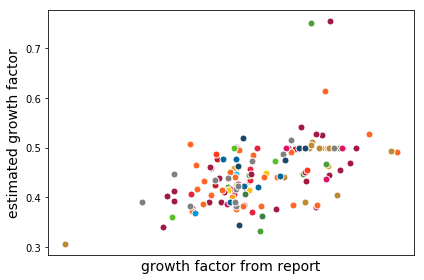

Calibrated 'steps':  29


In [7]:
alphas_rep = np.loadtxt('alphas.csv') # growth factors

arg_min = np.argmin(np.abs(np.array(rec_volas)-vola_emp))
best_alphas = rec_alphas[arg_min]
best_steps = rec_steps[arg_min]

for i in range(len(A)):
    plt.plot(alphas_rep[i], best_alphas[i], '.', mfc=colors[i], mec='white', markersize=14)
plt.xticks([])
plt.xlabel('growth factor from report', fontsize=14)
plt.ylabel('estimated growth factor', fontsize=14)

plt.tight_layout()
plt.show()
print("Calibrated 'steps': ", best_steps)